In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib
import os
from typing import Tuple, Dict, Any, List, Optional
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from abc import ABC, abstractmethod
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


In [3]:
cleaned_tweets_df = pd.read_csv('data/cleaned_apple_tweets.csv')
cleaned_tweets_df.head()

,tweet,product,tokens,processed_tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['g', 'iphon', 'hr', 'tweet', 'dead', 'need', ...",g iphon hr tweet dead need upgrad plugin station,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,"['know', 'awesom', 'ipadiphon', 'app', 'youll'...",know awesom ipadiphon app youll like appreci d...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['wait', 'also', 'sale']",wait also sale,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,"['hope', 'year', 'festiv', 'isnt', 'crashi', '...",hope year festiv isnt crashi year iphon app,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,"['great', 'stuff', 'fri', 'marissa', 'mayer', ...",great stuff fri marissa mayer googl tim oreill...,Positive emotion


In [4]:
class BaseDataProcessor:
    """Base class for data preprocessing operations"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.vectorizer = None
        self.feature_names = None
    
    def load_data(self, data_path: str = None, data_df: pd.DataFrame = None) -> pd.DataFrame:
        """Load data from file or dataframe"""
        if data_df is not None:
            return data_df
        elif data_path is not None:
            return pd.read_csv(data_path)
        else:
            raise ValueError("Either data_path or data_df must be provided")
    
    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Basic preprocessing steps"""
        # Handle missing values
        df = df.dropna(subset=['processed_tweet', 'sentiment'])
        
        # Clean sentiment labels
        df['sentiment'] = df['sentiment'].str.strip()
        
        return df
    
    def encode_labels(self, y: pd.Series) -> np.ndarray:
        """Encode string labels to numeric"""
        return self.label_encoder.fit_transform(y)
    
    def get_label_mapping(self) -> Dict[int, str]:
        """Get mapping from numeric labels to string labels"""
        return {i: label for i, label in enumerate(self.label_encoder.classes_)}

In [5]:
class FeatureExtractor(BaseDataProcessor):
    """Class for extracting features from text data"""
    
    def __init__(self, vectorizer_type: str = 'tfidf', max_features: int = 1000):
        super().__init__()
        self.vectorizer_type = vectorizer_type
        self.max_features = max_features
        self._initialize_vectorizer()
    
    def _initialize_vectorizer(self):
        """Initialize the appropriate vectorizer"""
        if self.vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(
                max_features=self.max_features,
                stop_words='english',
                lowercase=True,
                ngram_range=(1, 1)
            )
        elif self.vectorizer_type == 'count':
            self.vectorizer = CountVectorizer(
                max_features=self.max_features,
                stop_words='english',
                lowercase=True,
                ngram_range=(1, 2)
            )
        else:
            raise ValueError("vectorizer_type must be 'tfidf' or 'count'")
    
    def fit_transform_features(self, X_train: pd.Series, X_test: pd.Series = None) -> Tuple[np.ndarray, np.ndarray]:
        """Fit vectorizer on training data and transform both train and test"""
        X_train_vec = self.vectorizer.fit_transform(X_train)
        self.feature_names = self.vectorizer.get_feature_names()
        
        if X_test is not None:
            X_test_vec = self.vectorizer.transform(X_test)
            return X_train_vec.toarray(), X_test_vec.toarray()
        
        return X_train_vec.toarray(), None
    
    def get_feature_importance(self, model, top_n: int = 20) -> pd.DataFrame:
        """Get feature importance for models that support it"""
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_).mean(axis=0)
        else:
            raise ValueError("Model doesn't have feature importance or coefficients")
        
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance.head(top_n)

In [6]:
class DataSplitter:
    """Class for splitting data into train/validation/test sets"""
    
    def __init__(self, test_size: float = 0.2, val_size: float = 0.2, random_state: int = 42):
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
    
    def split_data(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Split data into train, validation, and test sets"""
        # First split: train+val vs test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        
        # Second split: train vs val
        val_size_adjusted = self.val_size / (1 - self.test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=self.random_state, stratify=y_temp
        )
        
        return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
class ModelEvaluator:
    """Class for evaluating model performance"""
    
    def __init__(self):
        self.results = {}
    
    def evaluate_model(self, model, X_test: np.ndarray, y_test: np.ndarray, model_name: str) -> Dict[str, Any]:
        """Evaluate model performance"""
        y_pred = model.predict(X_test)
        
        results = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'predictions': y_pred
        }
        
        self.results[model_name] = results
        return results
    
    def plot_confusion_matrix(self, model_name: str, labels: List[str] = None):
        """Plot confusion matrix for a model"""
        if model_name not in self.results:
            raise ValueError(f"Model {model_name} not found in results")
        
        cm = self.results[model_name]['confusion_matrix']
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
    
    def compare_models(self) -> pd.DataFrame:
        """Compare accuracy of all evaluated models"""
        comparison = pd.DataFrame([
            {'Model': name, 'Accuracy': results['accuracy']}
            for name, results in self.results.items()
        ]).sort_values('Accuracy', ascending=False)
        
        return comparison
    
    def plot_model_comparison(self):
        """Plot comparison of model accuracies"""
        comparison = self.compare_models()
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(comparison['Model'], comparison['Accuracy'])
        plt.title('Model Accuracy Comparison')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, acc in zip(bars, comparison['Accuracy']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [8]:
# Usage and testing
if __name__ == "__main__": 
    # Test the base classes
    df = cleaned_tweets_df
    
    # Test data processor
    processor = BaseDataProcessor()
    df_clean = processor.preprocess_data(df)
    y_encoded = processor.encode_labels(df_clean['sentiment'])
    label_mapping = processor.get_label_mapping()
    
    print("Data processing test:")
    print(f"Original shape: {df.shape}")
    print(f"Clean shape: {df_clean.shape}")
    print(f"Label mapping: {label_mapping}")
    print(f"Encoded labels: {y_encoded}")
    
    # Test feature extractor
    feature_extractor = FeatureExtractor(vectorizer_type='tfidf', max_features=100)
    X_train, _ = feature_extractor.fit_transform_features(df_clean['processed_tweet'])
    
    print(f"\nFeature extraction test:")
    print(f"Feature matrix shape: {X_train.shape}")
    print(f"Number of features: {len(feature_extractor.feature_names)}")
    
    print("\nBase classes setup complete!")

Data processing test:
Original shape: (9070, 5)
Clean shape: (9068, 5)
Label mapping: {0: "I can't tell", 1: 'Negative emotion', 2: 'No emotion toward brand or product', 3: 'Positive emotion'}
Encoded labels: [1 3 3 ... 2 2 2]

Feature extraction test:
Feature matrix shape: (9068, 100)
Number of features: 100

Base classes setup complete!


In [9]:
class BaseSentimentClassifier(ABC):
    """Abstract base class for sentiment classification models"""
    
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.model = None
        self.is_fitted = False
        self.best_params = None
        self.cv_scores = None
    
    @abstractmethod
    def _initialize_model(self) -> Any:
        """Initialize the specific model"""
        pass
    
    @abstractmethod
    def get_hyperparameters(self) -> Dict[str, Any]:
        """Get hyperparameters for grid search"""
        return {
            'C': [0.1, 1, 10],
            'solver': ['liblinear'],
            'penalty': ['l2']
        }
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fit the model"""
        if self.model is None:
            self.model = self._initialize_model()
        
        self.model.fit(X_train, y_train)
        self.is_fitted = True
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        return self.model.predict(X)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Get prediction probabilities"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        return self.model.predict_proba(X)
    
    def hyperparameter_tuning(self, X_train: np.ndarray, y_train: np.ndarray, 
                            cv: int = 3, scoring: str = 'accuracy') -> Dict[str, Any]:
        """Perform hyperparameter tuning using GridSearchCV"""
        if self.model is None:
            self.model = self._initialize_model()
        
        param_grid = self.get_hyperparameters()
        
        grid_search = GridSearchCV(
            self.model, param_grid, cv=cv, scoring=scoring, 
            n_jobs=-1, verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        self.model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        self.is_fitted = True
        
        return {
            'best_params': self.best_params,
            'best_score': grid_search.best_score_,
            'cv_results': grid_search.cv_results_
        }
    
    def cross_validate(self, X: np.ndarray, y: np.ndarray, cv: int = 5) -> Dict[str, float]:
        """Perform cross-validation"""
        if self.model is None:
            self.model = self._initialize_model()
        
        scores = cross_val_score(self.model, X, y, cv=cv, scoring='accuracy')
        self.cv_scores = scores
        
        return {
            'mean_score': scores.mean(),
            'std_score': scores.std(),
            'scores': scores
        }
    
    def save_model(self, filepath: str):
        """Save the trained model"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before saving")
        
        joblib.dump({
            'model': self.model,
            'model_name': self.model_name,
            'best_params': self.best_params
        }, filepath)
    
    def load_model(self, filepath: str):
        """Load a trained model"""
        data = joblib.load(filepath)
        self.model = data['model']
        self.model_name = data['model_name']
        self.best_params = data.get('best_params', None)
        self.is_fitted = True

In [10]:
class LogisticRegressionClassifier(BaseSentimentClassifier):
    """Logistic Regression classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("Logistic Regression")
        self.random_state = random_state
    
    def _initialize_model(self) -> LogisticRegression:
        return LogisticRegression(
            random_state=self.random_state,
            max_iter=1000,
            multi_class='ovr'
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs'],
            'penalty': ['l1', 'l2']
        }


In [11]:
class RandomForestSentimentClassifier(BaseSentimentClassifier):
    """Random Forest classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("Random Forest")
        self.random_state = random_state
    
    def _initialize_model(self) -> RandomForestClassifier:
        return RandomForestClassifier(
            random_state=self.random_state,
            n_jobs=-1
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

In [12]:
class DecisionTreeSentimentClassifier(BaseSentimentClassifier):
    """Decision Tree classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("Decision Tree")
        self.random_state = random_state
    
    def _initialize_model(self) -> DecisionTreeClassifier:
        return DecisionTreeClassifier(
            random_state=self.random_state
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }

In [13]:
class GradientBoostingSentimentClassifier(BaseSentimentClassifier):
    """Gradient Boosting classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("Gradient Boosting")
        self.random_state = random_state
    
    def _initialize_model(self) -> GradientBoostingClassifier:
        return GradientBoostingClassifier(
            random_state=self.random_state
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }

In [14]:
class XGBoostSentimentClassifier(BaseSentimentClassifier):
    """XGBoost classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("XGBoost")
        self.random_state = random_state
    
    def _initialize_model(self) -> Any:
        import xgboost as xgb
        return xgb.XGBClassifier(
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        }

In [15]:
class KNNSentimentClassifier(BaseSentimentClassifier):
    """K-Nearest Neighbors classifier for sentiment analysis"""
    
    def __init__(self):
        super().__init__("K-Nearest Neighbors")
    
    def _initialize_model(self) -> KNeighborsClassifier:
        return KNeighborsClassifier()
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'cosine']
        }

In [16]:
class NaiveBayesClassifier(BaseSentimentClassifier):
    """Naive Bayes classifier for sentiment analysis"""
    
    def __init__(self):
        super().__init__("Naive Bayes")
    
    def _initialize_model(self) -> MultinomialNB:
        return MultinomialNB()
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False]
        }

In [17]:
class MLPSentimentClassifier(BaseSentimentClassifier):
    """Multi-layer Perceptron classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("Neural Network (MLP)")
        self.random_state = random_state
    
    def _initialize_model(self) -> MLPClassifier:
        return MLPClassifier(
            random_state=self.random_state,
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }

In [18]:
class AdaBoostSentimentClassifier(BaseSentimentClassifier):
    """AdaBoost classifier for sentiment analysis"""
    
    def __init__(self, random_state: int = 42):
        super().__init__("AdaBoost")
        self.random_state = random_state
    
    def _initialize_model(self) -> AdaBoostClassifier:
        return AdaBoostClassifier(
            random_state=self.random_state
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.5, 1.0, 1.5],
            'algorithm': ['SAMME', 'SAMME.R']
        }

In [19]:
class ModelManager:
    """Class to manage multiple classification models"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def add_model(self, model: BaseSentimentClassifier):
        """Add a model to the manager"""
        self.models[model.model_name] = model
    
    def add_all_models(self, random_state: int = 42):
        """Add all available models"""
        models = [
            LogisticRegressionClassifier(random_state),
            DecisionTreeSentimentClassifier(random_state),
            RandomForestSentimentClassifier(random_state),
            XGBoostSentimentClassifier(random_state),
            GradientBoostingSentimentClassifier(random_state),
            KNNSentimentClassifier(),
            MLPSentimentClassifier(random_state),
            NaiveBayesClassifier(),
            AdaBoostSentimentClassifier(random_state)
        ]
        
        for model in models:
            self.add_model(model)
    
    def train_all_models(self, X_train: np.ndarray, y_train: np.ndarray, 
                        use_hyperparameter_tuning: bool = False):
        """Train all models"""
        print("Training all models...")
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            
            if use_hyperparameter_tuning:
                result = model.hyperparameter_tuning(X_train, y_train)
                print(f"Best parameters for {name}: {result['best_params']}")
                print(f"Best CV score: {result['best_score']:.4f}")
            else:
                model.fit(X_train, y_train)
                cv_result = model.cross_validate(X_train, y_train)
                print(f"CV score for {name}: {cv_result['mean_score']:.4f} (+/- {cv_result['std_score']:.4f})")
    
    def evaluate_all_models(self, evaluator: ModelEvaluator, X_test: np.ndarray, y_test: np.ndarray):
        """Evaluate all trained models"""
        print("\nEvaluating all models...")
        
        for name, model in self.models.items():
            if model.is_fitted:
                result = evaluator.evaluate_model(model, X_test, y_test, name)
                print(f"\n{name} - Test Accuracy: {result['accuracy']:.4f}")
    
    def get_best_model(self, evaluator: ModelEvaluator) -> Tuple[str, BaseSentimentClassifier]:
        """Get the best performing model"""
        if not evaluator.results:
            raise ValueError("No models have been evaluated yet")
        
        best_model_name = max(evaluator.results.keys(), 
                            key=lambda x: evaluator.results[x]['accuracy'])
        
        return best_model_name, self.models[best_model_name]
    
    def save_all_models(self, directory: str = "saved_models"):
        """Save all trained models"""
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        for name, model in self.models.items():
            if model.is_fitted:
                filepath = os.path.join(directory, f"{name.replace(' ', '_').lower()}_model.pkl")
                model.save_model(filepath)
                print(f"Saved {name} to {filepath}")


if __name__ == "__main__":
    print("Classification models setup complete!")
    print("\nAvailable models:")
    
    # Create model manager and add all models
    manager = ModelManager()
    manager.add_all_models()
    
    for model_name in manager.models.keys():
        print(f"- {model_name}")
    
    print(f"\nTotal models: {len(manager.models)}")

Classification models setup complete!

Available models:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient Boosting
- K-Nearest Neighbors
- Neural Network (MLP)
- Naive Bayes
- AdaBoost

Total models: 9


In [20]:
class EnsembleClassifier(BaseSentimentClassifier):
    """Base class for ensemble methods"""
    
    def __init__(self, model_name: str, base_models: List[BaseSentimentClassifier]):
        super().__init__(model_name)
        self.base_models = base_models
        self.fitted_models = []
    
    def _prepare_base_models(self) -> List[Tuple[str, Any]]:
        """Prepare base models for ensemble"""
        model_list = []
        for model in self.base_models:
            if model.model is None:
                model.model = model._initialize_model()
            model_list.append((model.model_name, model.model))
        return model_list

In [21]:
class VotingEnsemble(EnsembleClassifier):
    """Voting ensemble classifier"""
    
    def __init__(self, base_models: List[BaseSentimentClassifier], voting: str = 'soft'):
        super().__init__("Voting Ensemble", base_models)
        self.voting = voting
    
    def _initialize_model(self) -> VotingClassifier:
        estimators = self._prepare_base_models()
        return VotingClassifier(
            estimators=estimators,
            voting=self.voting
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'voting': ['soft', 'hard']
        }


In [22]:
class StackingEnsemble(EnsembleClassifier):
    """Stacking ensemble classifier"""
    
    def __init__(self, base_models: List[BaseSentimentClassifier], 
                 meta_classifier: BaseSentimentClassifier = None, cv: int = 5):
        super().__init__("Stacking Ensemble", base_models)
        self.meta_classifier = meta_classifier or LogisticRegressionClassifier()
        self.cv = cv
    
    def _initialize_model(self) -> StackingClassifier:
        estimators = self._prepare_base_models()
        
        if self.meta_classifier.model is None:
            self.meta_classifier.model = self.meta_classifier._initialize_model()
        
        return StackingClassifier(
            estimators=estimators,
            final_estimator=self.meta_classifier.model,
            cv=self.cv
        )
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'cv': [3, 5, 10]
        }

In [23]:
class WeightedEnsemble(BaseSentimentClassifier):
    """Weighted ensemble based on model performance"""
    
    def __init__(self, base_models: List[BaseSentimentClassifier], weights: List[float] = None):
        super().__init__("Weighted Ensemble")
        self.base_models = base_models
        self.weights = weights or [1.0] * len(base_models)
        self.num_classes = None
    
    def _initialize_model(self):
        # This ensemble doesn't use sklearn's interface
        return None
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {}
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fit all base models"""
        self.num_classes = len(np.unique(y_train))
        
        for model in self.base_models:
            if not model.is_fitted:
                model.fit(X_train, y_train)
        
        self.is_fitted = True
        return self
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Get weighted probability predictions"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        weighted_probs = np.zeros((X.shape[0], self.num_classes))
        total_weight = sum(self.weights)
        
        for model, weight in zip(self.base_models, self.weights):
            probs = model.predict_proba(X)
            weighted_probs += (weight / total_weight) * probs
        
        return weighted_probs
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions based on weighted probabilities"""
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
    
    def optimize_weights(self, X_val: np.ndarray, y_val: np.ndarray, 
                        method: str = 'accuracy') -> List[float]:
        """Optimize weights based on validation performance"""
        from scipy.optimize import minimize
        
        def objective(weights):
            self.weights = weights
            if method == 'accuracy':
                y_pred = self.predict(X_val)
                return -accuracy_score(y_val, y_pred)
            elif method == 'f1':
                y_pred = self.predict(X_val)
                return -f1_score(y_val, y_pred, average='weighted')
        
        # Initial weights
        initial_weights = np.ones(len(self.base_models)) / len(self.base_models)
        
        # Constraints: weights sum to 1 and are non-negative
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(len(self.base_models))]
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        
        self.weights = result.x.tolist()
        return self.weights

In [24]:
class BaggingEnsemble(BaseSentimentClassifier):
    """Bootstrap Aggregating ensemble"""
    
    def __init__(self, base_model_class: type, n_estimators: int = 10, 
                 max_samples: float = 0.8, random_state: int = 42):
        super().__init__("Bagging Ensemble")
        self.base_model_class = base_model_class
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.models = []
    
    def _initialize_model(self):
        return None
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'n_estimators': [5, 10, 20],
            'max_samples': [0.6, 0.8, 1.0]
        }
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fit multiple models on bootstrap samples"""
        np.random.seed(self.random_state)
        self.models = []
        
        n_samples = int(self.max_samples * len(X_train))
        
        for i in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(len(X_train), size=n_samples, replace=True)
            X_bootstrap = X_train[indices]
            y_bootstrap = y_train[indices]
            
            # Train model on bootstrap sample
            model = self.base_model_class(random_state=self.random_state + i)
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)
        
        self.is_fitted = True
        return self
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Average predictions from all models"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        predictions = np.array([model.predict_proba(X) for model in self.models])
        return np.mean(predictions, axis=0)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions by averaging"""
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

In [25]:
class CascadeEnsemble(BaseSentimentClassifier):
    """Cascade ensemble - models vote sequentially"""
    
    def __init__(self, base_models: List[BaseSentimentClassifier], 
                 confidence_threshold: float = 0.7):
        super().__init__("Cascade Ensemble")
        self.base_models = base_models
        self.confidence_threshold = confidence_threshold
    
    def _initialize_model(self):
        return None
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {
            'confidence_threshold': [0.6, 0.7, 0.8, 0.9]
        }
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fit all base models"""
        for model in self.base_models:
            if not model.is_fitted:
                model.fit(X_train, y_train)
        
        self.is_fitted = True
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions using cascade approach"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        n_samples = X.shape[0]
        predictions = np.full(n_samples, -1)
        remaining_indices = np.arange(n_samples)
        
        for model in self.base_models:
            if len(remaining_indices) == 0:
                break
            
            X_remaining = X[remaining_indices]
            probs = model.predict_proba(X_remaining)
            max_probs = np.max(probs, axis=1)
            
            # Find samples with high confidence
            confident_mask = max_probs >= self.confidence_threshold
            confident_indices = remaining_indices[confident_mask]
            
            # Make predictions for confident samples
            if len(confident_indices) > 0:
                confident_preds = np.argmax(probs[confident_mask], axis=1)
                predictions[confident_indices] = confident_preds
                
                # Remove confident samples from remaining
                remaining_indices = remaining_indices[~confident_mask]
        
        # Use last model for any remaining samples
        if len(remaining_indices) > 0:
            final_preds = self.base_models[-1].predict(X[remaining_indices])
            predictions[remaining_indices] = final_preds
        
        return predictions

In [26]:
class DynamicEnsemble(BaseSentimentClassifier):
    """Dynamic ensemble that selects best model per sample"""
    
    def __init__(self, base_models: List[BaseSentimentClassifier]):
        super().__init__("Dynamic Ensemble")
        self.base_models = base_models
        self.model_performance = {}
    
    def _initialize_model(self):
        return None
    
    def get_hyperparameters(self) -> Dict[str, Any]:
        return {}
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fit all models and evaluate their performance"""
        # Split training data for performance evaluation
        split_idx = int(0.8 * len(X_train))
        X_train_split = X_train[:split_idx]
        y_train_split = y_train[:split_idx]
        X_val_split = X_train[split_idx:]
        y_val_split = y_train[split_idx:]
        
        # Train all models
        for model in self.base_models:
            if not model.is_fitted:
                model.fit(X_train_split, y_train_split)
        
        # Evaluate performance on validation split
        for model in self.base_models:
            y_pred = model.predict(X_val_split)
            accuracy = accuracy_score(y_val_split, y_pred)
            self.model_performance[model.model_name] = accuracy
        
        # Retrain on full training data
        for model in self.base_models:
            model.fit(X_train, y_train)
        
        self.is_fitted = True
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Select best model for each sample based on confidence"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i in range(n_samples):
            X_sample = X[i:i+1]
            best_confidence = -1
            best_prediction = 0
            
            for model in self.base_models:
                probs = model.predict_proba(X_sample)
                confidence = np.max(probs)
                
                # Weight confidence by model performance
                weighted_confidence = confidence * self.model_performance[model.model_name]
                
                if weighted_confidence > best_confidence:
                    best_confidence = weighted_confidence
                    best_prediction = np.argmax(probs)
            
            predictions[i] = best_prediction
        
        return predictions.astype(int)

In [27]:
class EnsembleManager:
    """Manager for ensemble methods"""
    
    def __init__(self):
        self.ensembles = {}
    
    def create_voting_ensemble(self, base_models: List[BaseSentimentClassifier], 
                             voting: str = 'soft') -> VotingEnsemble:
        """Create voting ensemble"""
        ensemble = VotingEnsemble(base_models, voting)
        self.ensembles[f'Voting_{voting}'] = ensemble
        return ensemble
    
    def create_stacking_ensemble(self, base_models: List[BaseSentimentClassifier],
                               meta_classifier: BaseSentimentClassifier = None) -> StackingEnsemble:
        """Create stacking ensemble"""
        ensemble = StackingEnsemble(base_models, meta_classifier)
        self.ensembles['Stacking'] = ensemble
        return ensemble
    
    def create_weighted_ensemble(self, base_models: List[BaseSentimentClassifier],
                               weights: List[float] = None) -> WeightedEnsemble:
        """Create weighted ensemble"""
        ensemble = WeightedEnsemble(base_models, weights)
        self.ensembles['Weighted'] = ensemble
        return ensemble
    
    def create_bagging_ensemble(self, base_model_class: type, 
                              n_estimators: int = 10) -> BaggingEnsemble:
        """Create bagging ensemble"""
        ensemble = BaggingEnsemble(base_model_class, n_estimators)
        self.ensembles['Bagging'] = ensemble
        return ensemble
    
    def create_cascade_ensemble(self, base_models: List[BaseSentimentClassifier],
                              confidence_threshold: float = 0.7) -> CascadeEnsemble:
        """Create cascade ensemble"""
        ensemble = CascadeEnsemble(base_models, confidence_threshold)
        self.ensembles['Cascade'] = ensemble
        return ensemble
    
    def create_dynamic_ensemble(self, base_models: List[BaseSentimentClassifier]) -> DynamicEnsemble:
        """Create dynamic ensemble"""
        ensemble = DynamicEnsemble(base_models)
        self.ensembles['Dynamic'] = ensemble
        return ensemble
    
    def train_all_ensembles(self, X_train: np.ndarray, y_train: np.ndarray,
                          X_val: np.ndarray = None, y_val: np.ndarray = None):
        """Train all created ensembles"""
        print("Training ensemble methods...")
        
        for name, ensemble in self.ensembles.items():
            print(f"\nTraining {name}...")
            try:
                ensemble.fit(X_train, y_train)
                
                # Optimize weights for weighted ensemble
                if isinstance(ensemble, WeightedEnsemble) and X_val is not None:
                    print("Optimizing weights...")
                    optimal_weights = ensemble.optimize_weights(X_val, y_val)
                    print(f"Optimal weights: {optimal_weights}")
                
                print(f"{name} training completed.")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
    
    def evaluate_all_ensembles(self, evaluator: ModelEvaluator, 
                             X_test: np.ndarray, y_test: np.ndarray):
        """Evaluate all trained ensembles"""
        print("\nEvaluating ensemble methods...")
        
        for name, ensemble in self.ensembles.items():
            if ensemble.is_fitted:
                try:
                    result = evaluator.evaluate_model(ensemble, X_test, y_test, name)
                    print(f"\n{name} - Test Accuracy: {result['accuracy']:.4f}")
                except Exception as e:
                    print(f"Error evaluating {name}: {str(e)}")

In [28]:
# Advanced feature engineering class
class AdvancedFeatureEngineer:
    """Advanced feature engineering techniques"""
    
    def __init__(self):
        self.feature_combinations = []
    
    def create_feature_interactions(self, X: np.ndarray, top_features: int = 100) -> np.ndarray:
        """Create feature interactions"""
        # Select top features based on variance
        feature_vars = np.var(X, axis=0)
        top_indices = np.argsort(feature_vars)[-top_features:]
        
        X_top = X[:, top_indices]
        
        # Create pairwise interactions
        interactions = []
        for i in range(X_top.shape[1]):
            for j in range(i+1, X_top.shape[1]):
                interaction = X_top[:, i] * X_top[:, j]
                interactions.append(interaction.reshape(-1, 1))
        
        if interactions:
            X_interactions = np.hstack(interactions)
            return np.hstack([X, X_interactions])
        
        return X
    
    def create_polynomial_features(self, X: np.ndarray, degree: int = 2, 
                                 max_features: int = 1000) -> np.ndarray:
        """Create polynomial features"""
        from sklearn.preprocessing import PolynomialFeatures
        
        # Limit features to avoid memory issues
        if X.shape[1] > max_features:
            X = X[:, :max_features]
        
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X)
        
        return X_poly
    
    def create_statistical_features(self, X: np.ndarray) -> np.ndarray:
        """Create statistical features"""
        # Row-wise statistics
        row_mean = np.mean(X, axis=1).reshape(-1, 1)
        row_std = np.std(X, axis=1).reshape(-1, 1)
        row_max = np.max(X, axis=1).reshape(-1, 1)
        row_min = np.min(X, axis=1).reshape(-1, 1)
        row_median = np.median(X, axis=1).reshape(-1, 1)
        
        statistical_features = np.hstack([
            row_mean, row_std, row_max, row_min, row_median
        ])
        
        return np.hstack([X, statistical_features])

In [29]:
# Usage
if __name__ == "__main__":
    print("Ensemble methods and advanced techniques setup complete!")
    print("\nAvailable ensemble methods:")
    print("- Voting Ensemble (Hard/Soft)")
    print("- Stacking Ensemble")
    print("- Weighted Ensemble")
    print("- Bagging Ensemble")
    print("- Cascade Ensemble")
    print("- Dynamic Ensemble")
    print("\nAdvanced feature engineering available:")
    print("- Feature interactions")
    print("- Polynomial features")
    print("- Statistical features")

Ensemble methods and advanced techniques setup complete!

Available ensemble methods:
- Voting Ensemble (Hard/Soft)
- Stacking Ensemble
- Weighted Ensemble
- Bagging Ensemble
- Cascade Ensemble
- Dynamic Ensemble

Advanced feature engineering available:
- Feature interactions
- Polynomial features
- Statistical features


In [30]:
# Import all our custom classes
# (In practice, these would be imported from separate modules)
# from tweet_sentiment_base import *
# from tweet_sentiment_models import *
# from tweet_sentiment_ensemble import *

class TweetSentimentPipeline:
    """Complete pipeline for tweet sentiment analysis"""
    
    def __init__(self, data_path: str = None, data_df: pd.DataFrame = None):
        self.data_path = data_path
        self.data_df = data_df
        
        # Initialize components
        self.data_processor = BaseDataProcessor()
        self.feature_extractor = FeatureExtractor()
        self.data_splitter = DataSplitter()
        self.evaluator = ModelEvaluator()
        self.model_manager = ModelManager()
        self.ensemble_manager = EnsembleManager()
        self.feature_engineer = AdvancedFeatureEngineer()
        
        # Data storage
        self.df_clean = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.label_mapping = None
        
        # Results
        self.results_summary = {}
    
    def load_and_preprocess_data(self, use_advanced_features: bool = False):
        """Load and preprocess the data"""
        print("Loading and preprocessing data...")
        
        # Load data
        if self.data_df is not None:
            df = self.data_df.copy()
        else:
            df = pd.read_csv(self.data_path)
        
        print(f"Original data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Basic preprocessing
        self.df_clean = self.data_processor.preprocess_data(df)
        print(f"Clean data shape: {self.df_clean.shape}")
        
        # Display sentiment distribution
        print("\nSentiment distribution:")
        print(self.df_clean['sentiment'].value_counts())
        
        # Encode labels
        y = self.data_processor.encode_labels(self.df_clean['sentiment'])
        self.label_mapping = self.data_processor.get_label_mapping()
        print(f"\nLabel mapping: {self.label_mapping}")
        
        # Extract features
        print("\nExtracting features...")
        X_train_base, X_test_base = self.feature_extractor.fit_transform_features(
            self.df_clean['processed_tweet']
        )
        
        if X_test_base is None:
            X_features = X_train_base
        else:
            X_features = np.vstack([X_train_base, X_test_base])
        
        print(f"Feature matrix shape: {X_features.shape}")
        
        # Advanced feature engineering
        if use_advanced_features:
            print("Applying advanced feature engineering...")
            
            # Create feature interactions
            X_features = self.feature_engineer.create_feature_interactions(X_features)
            print(f"After interactions: {X_features.shape}")
            
            # Create statistical features
            X_features = self.feature_engineer.create_statistical_features(X_features)
            print(f"After statistical features: {X_features.shape}")
        
        # Split data
        print("\nSplitting data...")
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = \
            self.data_splitter.split_data(X_features, y)
        
        print(f"Train set: {self.X_train.shape}")
        print(f"Validation set: {self.X_val.shape}")
        print(f"Test set: {self.X_test.shape}")
        
        return self
    
    def train_individual_models(self, use_hyperparameter_tuning: bool = False):
        """Train individual classification models"""
        print("\n" + "="*50)
        print("TRAINING INDIVIDUAL MODELS")
        print("="*50)
        
        # Add all models to manager
        self.model_manager.add_all_models()
        
        # Train all models
        self.model_manager.train_all_models(
            self.X_train, self.y_train, 
            use_hyperparameter_tuning=use_hyperparameter_tuning
        )
        
        # Evaluate all models
        self.model_manager.evaluate_all_models(
            self.evaluator, self.X_test, self.y_test
        )
        
        return self
    
    def train_ensemble_models(self):
        """Train ensemble models"""
        print("\n" + "="*50)
        print("TRAINING ENSEMBLE MODELS")
        print("="*50)
        
        # Get top performing individual models for ensembles
        individual_results = self.evaluator.compare_models()
        top_models = individual_results.head(5)['Model'].tolist()
        
        print(f"Using top {len(top_models)} models for ensembles: {top_models}")
        
        # Get the actual model objects
        base_models = [self.model_manager.models[name] for name in top_models 
                      if name in self.model_manager.models]
        
        if len(base_models) < 2:
            print("Need at least 2 trained models for ensemble. Skipping ensemble training.")
            return self
        
        # Create different ensemble types
        print("\nCreating ensemble methods...")
        
        # Voting ensembles
        voting_soft = self.ensemble_manager.create_voting_ensemble(base_models, 'soft')
        voting_hard = self.ensemble_manager.create_voting_ensemble(base_models, 'hard')
        
        # Stacking ensemble
        stacking = self.ensemble_manager.create_stacking_ensemble(base_models)
        
        # Weighted ensemble
        weighted = self.ensemble_manager.create_weighted_ensemble(base_models)
        
        # Bagging ensemble with best individual model
        best_model_name = individual_results.iloc[0]['Model']
        if best_model_name in self.model_manager.models:
            best_model_class = type(self.model_manager.models[best_model_name])
            bagging = self.ensemble_manager.create_bagging_ensemble(best_model_class, n_estimators=10)
        
        # Cascade ensemble
        cascade = self.ensemble_manager.create_cascade_ensemble(base_models)
        
        # Dynamic ensemble
        dynamic = self.ensemble_manager.create_dynamic_ensemble(base_models)
        
        # Train all ensembles
        self.ensemble_manager.train_all_ensembles(
            self.X_train, self.y_train, self.X_val, self.y_val
        )
        
        # Evaluate all ensembles
        self.ensemble_manager.evaluate_all_ensembles(
            self.evaluator, self.X_test, self.y_test
        )
        
        return self
    
    def analyze_results(self):
        """Analyze and visualize results"""
        print("\n" + "="*50)
        print("RESULTS ANALYSIS")
        print("="*50)
        
        # Get comparison of all models
        comparison = self.evaluator.compare_models()
        print("\nModel Performance Comparison:")
        print(comparison)
        
        # Plot comparison
        self.evaluator.plot_model_comparison()
        
        # Get best model
        best_model_name, best_model = self.model_manager.get_best_model(self.evaluator)
        print(f"\nBest Model: {best_model_name}")
        print(f"Best Accuracy: {self.evaluator.results[best_model_name]['accuracy']:.4f}")
        
        # Detailed analysis of best model
        print(f"\nDetailed Classification Report for {best_model_name}:")
        print(self.evaluator.results[best_model_name]['classification_report'])
        
        # Plot confusion matrix for best model
        label_names = [self.label_mapping[i] for i in sorted(self.label_mapping.keys())]
        self.evaluator.plot_confusion_matrix(best_model_name, label_names)
        
        # Feature importance analysis
        try:
            feature_importance = self.feature_extractor.get_feature_importance(best_model, top_n=15)
            print(f"\nTop 15 Features for {best_model_name}:")
            print(feature_importance)
            
            # Plot feature importance
            plt.figure(figsize=(10, 8))
            plt.barh(range(len(feature_importance)), feature_importance['importance'])
            plt.yticks(range(len(feature_importance)), feature_importance['feature'])
            plt.xlabel('Importance')
            plt.title(f'Top Features - {best_model_name}')
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not analyze feature importance: {str(e)}")
        
        # Store results summary
        self.results_summary = {
            'best_model': best_model_name,
            'best_accuracy': self.evaluator.results[best_model_name]['accuracy'],
            'all_results': comparison,
            'label_mapping': self.label_mapping
        }
        
        return self
    
    def predict_new_samples(self, texts: List[str], model_name: str = None):
        """Predict sentiment for new text samples"""
        if model_name is None:
            model_name = self.results_summary['best_model']
        
        # Get the model
        if model_name in self.model_manager.models:
            model = self.model_manager.models[model_name]
        elif model_name in self.ensemble_manager.ensembles:
            model = self.ensemble_manager.ensembles[model_name]
        else:
            raise ValueError(f"Model {model_name} not found")
        
        # Preprocess texts (basic preprocessing)
        processed_texts = [text.lower().strip() for text in texts]
        
        # Transform features
        X_new = self.feature_extractor.vectorizer.transform(processed_texts).toarray()
        
        # Make predictions
        predictions = model.predict(X_new)
        probabilities = model.predict_proba(X_new)
        
        # Convert predictions to labels
        predicted_labels = [self.label_mapping[pred] for pred in predictions]
        
        # Create results dataframe
        results_df = pd.DataFrame({
            'text': texts,
            'predicted_sentiment': predicted_labels,
            'confidence': np.max(probabilities, axis=1)
        })
        
        return results_df
    
    def save_models(self, directory: str = "saved_models"):
        """Save all trained models"""
        print(f"\nSaving models to {directory}...")
        self.model_manager.save_all_models(directory)
        
        # Save feature extractor
        import joblib
        joblib.dump(self.feature_extractor, f"{directory}/feature_extractor.pkl")
        joblib.dump(self.data_processor, f"{directory}/data_processor.pkl")
        
        print("All models saved successfully!")
    
    def generate_report(self):
        """Generate comprehensive report"""
        print("\n" + "="*60)
        print("COMPREHENSIVE SENTIMENT ANALYSIS REPORT")
        print("="*60)
        
        print(f"\nDataset Information:")
        print(f"- Total samples: {len(self.df_clean)}")
        print(f"- Features: {self.X_train.shape[1]}")
        print(f"- Classes: {len(self.label_mapping)}")
        
        print(f"\nClass Distribution:")
        for label, count in self.df_clean['sentiment'].value_counts().items():
            print(f"- {label}: {count} ({count/len(self.df_clean)*100:.1f}%)")
        
        print(f"\nModel Performance Summary:")
        comparison = self.evaluator.compare_models()
        for _, row in comparison.iterrows():
            print(f"- {row['Model']}: {row['Accuracy']:.4f}")
        
        print(f"\nBest Model: {self.results_summary['best_model']}")
        print(f"Best Accuracy: {self.results_summary['best_accuracy']:.4f}")
        
        print(f"\nRecommendations:")
        if self.results_summary['best_accuracy'] > 0.85:
            print("- Excellent performance! Model is ready for production.")
        elif self.results_summary['best_accuracy'] > 0.75:
            print("- Good performance. Consider more data or feature engineering.")
        else:
            print("- Performance needs improvement. Consider:")
            print("  * More training data")
            print("  * Better feature engineering")
            print("  * Different preprocessing approaches")
            print("  * Advanced deep learning models")

# def run_minimal_pipeline(data_df:pd.DataFrame):
#     """Run a minimal sentiment analysis pipeline."""
    
#     pipeline = TweetSentimentPipeline(data_df=data_df)
    
#     # Preprocess data and extract features
#     pipeline.load_and_preprocess_data(use_advanced_features=False)
    
#     # Train key models
#     pipeline.model_manager.add_model(LogisticRegressionClassifier())
#     pipeline.model_manager.add_model(RandomForestSentimentClassifier())
#     pipeline.model_manager.add_model(GradientBoostingSentimentClassifier())
#     pipeline.model_manager.add_model(KNNSentimentClassifier())

#     pipeline.train_individual_models(use_hyperparameter_tuning=True)
    
#     # Analyze model results and visualize
#     pipeline.analyze_results()
    
#     return pipeline

# Usage function
def run_complete_pipeline(data_df: pd.DataFrame, use_advanced_features: bool = False,
                         use_hyperparameter_tuning: bool = False):
    """Run the complete sentiment analysis pipeline."""
    
    pipeline = TweetSentimentPipeline(data_df=data_df)
    
    # Step 1: Preprocess data and extract features
    pipeline.load_and_preprocess_data(use_advanced_features=use_advanced_features)
    
    # Step 2: Train individual models
    pipeline.train_individual_models(use_hyperparameter_tuning=use_hyperparameter_tuning)
    
    # Step 3: Train ensemble models
    pipeline.train_ensemble_models()
    
    # Step 4: Analyze model results and visualize
    pipeline.analyze_results()
    
    # Step 5 (Optional): Save trained models
    pipeline.save_models()
    
    # Step 6 (Optional): Generate a report
    pipeline.generate_report()
    
    return pipeline


Loading and preprocessing data...
Original data shape: (2721, 5)
Columns: ['tweet', 'product', 'tokens', 'processed_tweet', 'sentiment']
Clean data shape: (2720, 5)

Sentiment distribution:
No emotion toward brand or product    1673
Positive emotion                       819
Negative emotion                       179
I can't tell                            49
Name: sentiment, dtype: int64

Label mapping: {0: "I can't tell", 1: 'Negative emotion', 2: 'No emotion toward brand or product', 3: 'Positive emotion'}

Extracting features...
Feature matrix shape: (2720, 1000)

Splitting data...
Train set: (1632, 1000)
Validation set: (544, 1000)
Test set: (544, 1000)

TRAINING INDIVIDUAL MODELS
Training all models...

Training Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   14.1s finished


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.6428

Training Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   34.9s finished


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.6397

Training Gradient Boosting...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 58.8min finished


Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.6354

Training K-Nearest Neighbors...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.5s finished


Best parameters for K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best CV score: 0.6348

Training Decision Tree...
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.6121

Training Neural Network (MLP)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   55.7s finished


Best parameters for Neural Network (MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
Best CV score: 0.6379

Training Naive Bayes...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters for Naive Bayes: {'alpha': 0.5, 'fit_prior': True}
Best CV score: 0.6324

Training AdaBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished


Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Best CV score: 0.6225

Evaluating all models...

Logistic Regression - Test Accuracy: 0.6544

Random Forest - Test Accuracy: 0.6397

Gradient Boosting - Test Accuracy: 0.6507

K-Nearest Neighbors - Test Accuracy: 0.6213

Decision Tree - Test Accuracy: 0.6140

Neural Network (MLP) - Test Accuracy: 0.6250

Naive Bayes - Test Accuracy: 0.6195

AdaBoost - Test Accuracy: 0.6121

RESULTS ANALYSIS

Model Performance Comparison:
                  Model  Accuracy
0   Logistic Regression  0.654412
2     Gradient Boosting  0.650735
1         Random Forest  0.639706
5  Neural Network (MLP)  0.625000
3   K-Nearest Neighbors  0.621324
6           Naive Bayes  0.619485
4         Decision Tree  0.613971
7              AdaBoost  0.612132


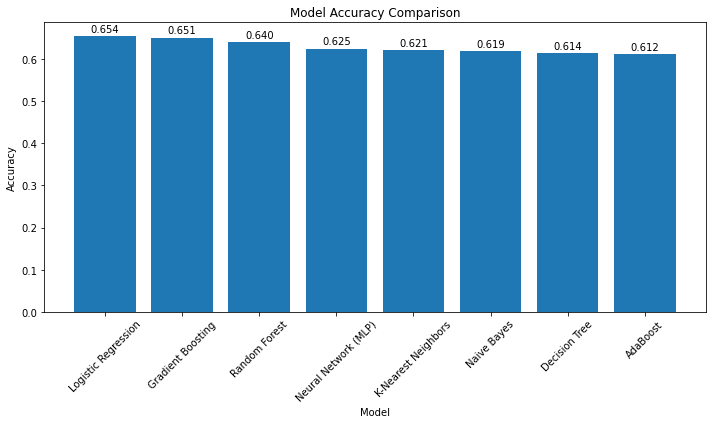


Best Model: Logistic Regression
Best Accuracy: 0.6544

Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        36
           2       0.66      0.94      0.78       334
           3       0.61      0.25      0.35       164

    accuracy                           0.65       544
   macro avg       0.32      0.30      0.28       544
weighted avg       0.59      0.65      0.58       544



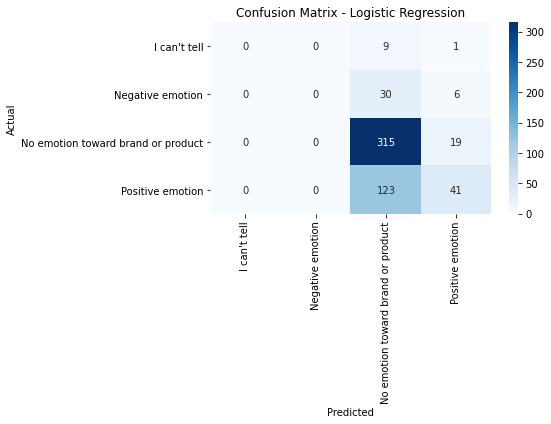

Could not analyze feature importance: Model doesn't have feature importance or coefficients


In [ ]:
# Run the full pipeline
# sample_df = cleaned_tweets_df.sample(frac=0.3, random_state=42)
# pipeline = run_minimal_pipeline(data_df=sample_df)


Loading and preprocessing data...
Original data shape: (2721, 5)
Columns: ['tweet', 'product', 'tokens', 'processed_tweet', 'sentiment']
Clean data shape: (2720, 5)

Sentiment distribution:
No emotion toward brand or product    1673
Positive emotion                       819
Negative emotion                       179
I can't tell                            49
Name: sentiment, dtype: int64

Label mapping: {0: "I can't tell", 1: 'Negative emotion', 2: 'No emotion toward brand or product', 3: 'Positive emotion'}

Extracting features...
Feature matrix shape: (2720, 1000)

Splitting data...
Train set: (1632, 1000)
Validation set: (544, 1000)
Test set: (544, 1000)

TRAINING INDIVIDUAL MODELS
Training all models...

Training Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.2s finished


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.6428

Training Decision Tree...
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.6121

Training Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   24.5s finished


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.6397

Training Gradient Boosting...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 54.1min finished


Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.6354

Training K-Nearest Neighbors...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.2s finished


Best parameters for K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best CV score: 0.6348

Training Neural Network (MLP)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.0min finished


Best parameters for Neural Network (MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
Best CV score: 0.6379

Training Naive Bayes...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters for Naive Bayes: {'alpha': 0.5, 'fit_prior': True}
Best CV score: 0.6324

Training AdaBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.1min finished


Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Best CV score: 0.6225

Evaluating all models...

Logistic Regression - Test Accuracy: 0.6544

Decision Tree - Test Accuracy: 0.6140

Random Forest - Test Accuracy: 0.6397

Gradient Boosting - Test Accuracy: 0.6507

K-Nearest Neighbors - Test Accuracy: 0.6213

Neural Network (MLP) - Test Accuracy: 0.6250

Naive Bayes - Test Accuracy: 0.6195

AdaBoost - Test Accuracy: 0.6121

TRAINING ENSEMBLE MODELS
Using top 5 models for ensembles: ['Logistic Regression', 'Gradient Boosting', 'Random Forest', 'Neural Network (MLP)', 'K-Nearest Neighbors']

Creating ensemble methods...
Training ensemble methods...

Training Voting_soft...
Voting_soft training completed.

Training Voting_hard...
Voting_hard training completed.

Training Stacking...
Stacking training completed.

Training Weighted...
Optimizing weights...
Optimal weights: [0.2, 0.2, 0.2, 0.2, 0.2]
Weighted training completed.

Training Bagging..

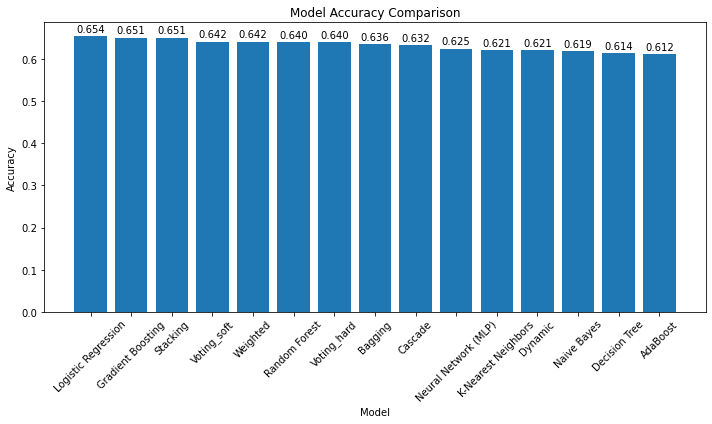


Best Model: Logistic Regression
Best Accuracy: 0.6544

Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        36
           2       0.66      0.94      0.78       334
           3       0.61      0.25      0.35       164

    accuracy                           0.65       544
   macro avg       0.32      0.30      0.28       544
weighted avg       0.59      0.65      0.58       544



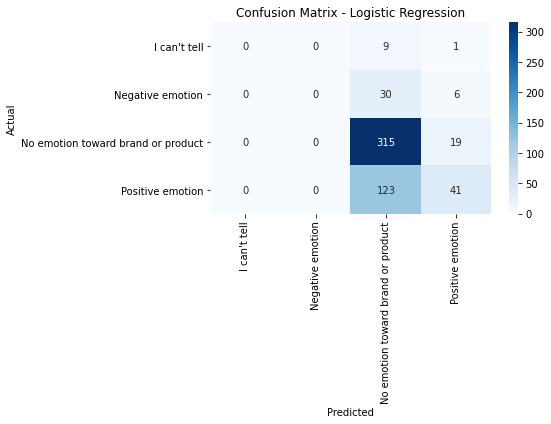

Could not analyze feature importance: Model doesn't have feature importance or coefficients

Saving models to saved_models...
Saved Logistic Regression to saved_models\logistic_regression_model.pkl
Saved Decision Tree to saved_models\decision_tree_model.pkl
Saved Random Forest to saved_models\random_forest_model.pkl
Saved Gradient Boosting to saved_models\gradient_boosting_model.pkl
Saved K-Nearest Neighbors to saved_models\k-nearest_neighbors_model.pkl
Saved Neural Network (MLP) to saved_models\neural_network_(mlp)_model.pkl
Saved Naive Bayes to saved_models\naive_bayes_model.pkl
Saved AdaBoost to saved_models\adaboost_model.pkl
All models saved successfully!

COMPREHENSIVE SENTIMENT ANALYSIS REPORT

Dataset Information:
- Total samples: 2720
- Features: 1000
- Classes: 4

Class Distribution:
- No emotion toward brand or product: 1673 (61.5%)
- Positive emotion: 819 (30.1%)
- Negative emotion: 179 (6.6%)
- I can't tell: 49 (1.8%)

Model Performance Summary:
- Logistic Regression: 0.65

In [ ]:
# pipeline = run_complete_pipeline(data_df=sample_df,
#                                  use_advanced_features=False,
#                                  use_hyperparameter_tuning=True)